In [6]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Global functions

In [1]:
# Choose club to see results in the season, lowercase names with no space between words
def get_club_results(dt, club):

    f, ax = plt.subplots(1, 2, figsize=(15,8))

    labels = ['Home wins', 'Away wins', 'Draw']
    
    
    for ai, place in zip(range(2), ['home', 'away']):
    
        results = dt['result'][dt[place] == club].value_counts()

        ax[ai].set_title(f'{club} results {place} - {dt.year.unique()[0]}')
        for i, v in zip(results.index, results.values):
            ax[ai].bar(i, v, label=labels[int(i)])
            ax[ai].text(x = i - 0.05, y = v + 0.05, s = v, size = 12)
        ax[ai].legend()

In [2]:
# Verify clubs points at the end of season
def get_final_table(dt):
    clubs = dt['home'].sort_values().unique()

    final_table = pd.DataFrame({'Club': [], 'Points': []})
    for club in clubs:
        data_home = dt[dt['home'] == club]
        data_away = dt[dt['away'] == club]
        home_results = data_home['result'].map({0: 3, 1: 0, 2: 1}).sum()
        away_results = data_away['result'].map({0: 0, 1: 3, 2: 1}).sum()

        final_table = final_table.append({'Club': club,
                                          'Points': home_results + away_results},
                                         ignore_index=True)

    return final_table.sort_values(by='Points', ascending=False).reset_index(drop=True)

In [3]:
def get_result(result_line):
    if result_line[0] > result_line[1]:
        return 0
    elif result_line[0] < result_line[1]:
        return 1
    else:
        return 2

def get_final_dt(results, clubs, year):
    final_dt = pd.DataFrame({'home': [],
                              'away': [],
                              'result': [], })
    for r, c in zip(results, clubs):
        result = get_result(r)
        final_dt = final_dt.append({
            'home': c[0].lower().replace(' ', '').replace('-', ''),
            'away': c[1].lower().replace(' ', '').replace('-', ''),
            'result': result,
        }, ignore_index=True)
    
    final_dt = final_dt.assign(year = year)
    
    return final_dt

### Years of 2003, 2004 and 2006

In [9]:
# years of 2003, 2004 and 2006
def get_data_1(year):
    #read txt
    dt = pd.read_csv(f'br-brazil/{year}/brasileirao-seriea.txt', header=None)
    
    # get lines with results
    dt = dt[dt[0].str.contains('\dx\d')].reset_index(drop=True)
    
    without_scores = dt[0].str.replace(r'\d[x]\d', '')

    clubs = []
    for line in without_scores.values:
        aux = re.findall(r'\s\w+\s\w+ | \w+[-]\w+ | \w+', line)
        clubs.append([aux[0], aux[1]])
    
    clubs = np.asarray(clubs).astype(np.object)
    
    find_scores = dt[0].str.findall(r'\d[x]\d')

    results = []
    for r in find_scores:
        results.append(re.findall(r'\d+', r[0]))

    results = np.asarray(results).astype(np.int)
    
    return get_final_dt(results, clubs, year)

In [7]:
dt = get_data_1('2004')

# get_club_results(dt, 'vasco')
dt

,home,away,result,year
0,botafogo,goiás,1.0,2004
1,figueirense,internacional,0.0,2004
2,sãocaetano,vitória,0.0,2004
3,cruzeiro,juventude,0.0,2004
4,palmeiras,atléticomg,2.0,2004
5,grêmio,flamengo,2.0,2004
6,pontepreta,corinthians,0.0,2004
7,paraná,santos,0.0,2004
8,coritiba,guarani,0.0,2004
9,vasco,criciúma,1.0,2004


In [769]:
get_final_table(dt)

,Club,Points
0,santos,89.0
1,atléticopr,86.0
2,sãopaulo,83.0
3,palmeiras,79.0
4,sãocaetano,78.0
5,corinthians,74.0
6,goiás,72.0
7,juventude,70.0
8,fluminense,67.0
9,internacional,67.0


### Year of 2005

In [10]:
# year of 2005
def get_data_2(year):
    #read txt
    dt = pd.read_csv(f'br-brazil/{year}/brasileirao-seriea.txt', header=None)
    
    # get lines with results
    dt = dt[dt[0].str.contains('(\dx\d) | (\d - \d)')].reset_index(drop=True)

    without_scores = dt[0].str.replace(r'\d - \d', '')
    without_scores = without_scores.str.replace(r'\d[x]\d', '')
    without_scores = without_scores.str.replace(r'Atlético - MG', 'Atlético-MG')

    clubs = []
    for line in without_scores.values:
        aux = re.findall(r' \w+[-]\w+ |\w+[-]\w+| \w+ \w+ | \w+', line)
        clubs.append([aux[0], aux[1]])

    clubs = np.asarray(clubs).astype(np.object)
    
    find_results_1 = dt[0].str.findall(r'\d[x]\d')
    find_results_2 = dt[0].str.findall(r'\d - \d')
    find_results = find_results_1 + find_results_2

    results = []
    for r in find_results:
        results.append(re.findall(r'\d+', r[0]))

    results = np.asarray(results).astype(np.int)
    
    return get_final_dt(results, clubs, year)

/home/paulorocha/Documents/DataScienceBrChallenge/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


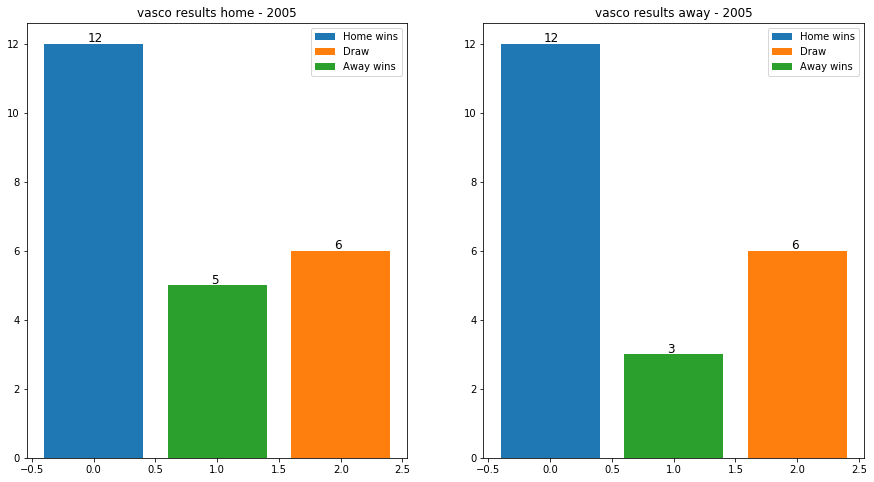

In [770]:
dt = get_data_2('2005')

get_club_results(dt, 'vasco')

In [772]:
get_final_table(dt)

,Club,Points
0,internacional,81.0
1,corinthians,81.0
2,goiás,74.0
3,fluminense,71.0
4,palmeiras,70.0
5,cruzeiro,66.0
6,botafogo,62.0
7,santos,62.0
8,sãopaulo,61.0
9,paraná,61.0


### Years of 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017

In [11]:
# year of 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016 and 2017
def get_data_3(year):
    #read txt
    
    if year == '2017':
        dt = pd.read_csv(f'br-brazil/{year}/brasileirao-seriea.txt', header=None, error_bad_lines=False)
    else:
        dt = pd.read_csv(f'br-brazil/{year}/brasileirao-seriea.txt', header=None)
    
    if year in ['2011', '2012', '2013', '2014', '2015', '2016', '2017']:
        reg_score = r'\d - \d'
    else:
        reg_score = r'\d-\d'
    
    # get lines with results
    dt = dt[dt[0].str.contains(reg_score)].reset_index(drop=True)
    
    without_scores = dt[0].str.replace(reg_score, '')
    without_scores = without_scores.str.replace(r'Vasco da Gama', 'Vasco')

    clubs = []
    for line in without_scores.values:
        aux = re.findall(r'\w+[-]\w+|\w+ \w+|\w+', line)
        clubs.append([aux[0], aux[1]])

    clubs = np.asarray(clubs).astype(np.object)
    
    find_results = dt[0].str.findall(reg_score)
    
    results = []
    for r in find_results:
        results.append(re.findall(r'\d+', r[0]))

    results = np.asarray(results).astype(np.int)
    
    return get_final_dt(results, clubs, year)

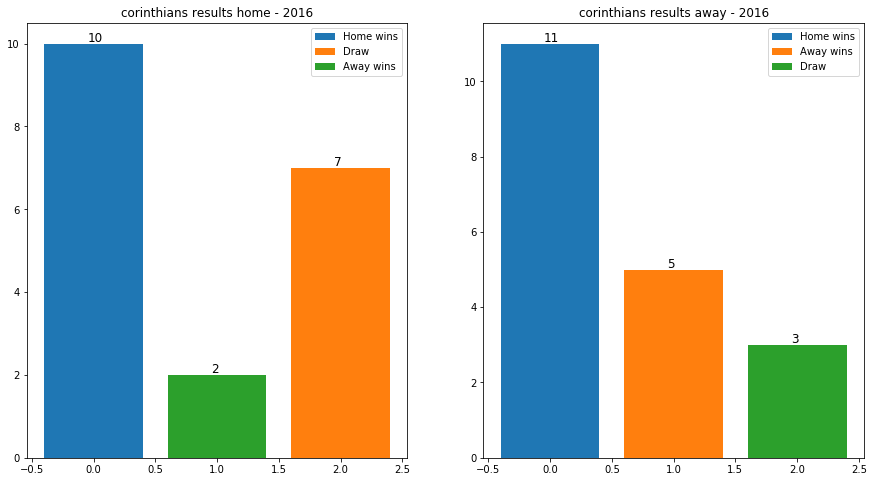

In [789]:
dt = get_data_3('2016')

get_club_results(dt, 'corinthians')

In [791]:
get_final_table(dt)

,Club,Points
0,palmeiras,80.0
1,santos,71.0
2,flamengo,71.0
3,atléticomg,62.0
4,botafogo,59.0
5,atléticopr,57.0
6,corinthians,55.0
7,grêmio,53.0
8,pontepreta,53.0
9,chapecoense,52.0


### Mergin data

In [64]:
data = pd.DataFrame()

# Data of 2003, 2004
for year in ['2003', '2004']:
    data = pd.concat([data, get_data_1(year)], ignore_index=True)

# Data of 2005
data = pd.concat([data, get_data_2('2005')], ignore_index=True)

# Data of 2006
data = pd.concat([data, get_data_1('2006')], ignore_index=True)

# Data of 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015 and 2016
for year in ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']:
    data = pd.concat([data, get_data_3(year)], ignore_index=True)

data.to_csv('brasileiraoseriea_2003_2016.csv', index=False)
data.head()

/home/paulorocha/Documents/DataScienceBrChallenge/env/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  import sys


,home,away,result,year
0,guarani,vasco,0.0,2003
1,atléticopr,grêmio,0.0,2003
2,flamengo,coritiba,2.0,2003
3,goiás,paysandu,2.0,2003
4,internacional,pontepreta,2.0,2003
5,criciúma,fluminense,0.0,2003
6,juventude,sãopaulo,2.0,2003
7,fortaleza,bahia,2.0,2003
8,cruzeiro,sãocaetano,2.0,2003
9,vitória,figueirense,2.0,2003


In [128]:
def insert_previous_results(data, n_games=50):
    aux_data = pd.DataFrame()
    for i, row in test.iterrows():
        home = row[0] 
        away = row[1]
        result = row[2]

        if i - n_games >= 0:
            last_games = data.iloc[:i,:].tail(n_games)

            home_prev = last_games['result'][(last_games['home'] == home) & (last_games['result'] == 0)].shape[0]
            home_prev += last_games['result'][(last_games['away'] == home) & (last_games['result'] == 1)].shape[0]

            away_prev = last_games['result'][(last_games['home'] == away) & (last_games['result'] == 0)].shape[0]
            away_prev += last_games['result'][(last_games['away'] == away) & (last_games['result'] == 1)].shape[0]

            aux_data = aux_data.append({'home previous': home_prev,
                                        'away previous': away_prev}, ignore_index=True)
        else:
            aux_data = aux_data.append({'home previous': 0,
                                        'away previous': 0}, ignore_index=True)
    data['home previous'] = aux_data['home previous']
    data['away previous'] = aux_data['away previous']
    
    return data

data = insert_previous_results(data)
data.to_csv('brasileiraoseriea_2003_2016_with_previous.csv', index=False)
data.head()

,home,away,result,year,home previous,away previous
0,guarani,vasco,0.0,2003,0.0,0.0
1,atléticopr,grêmio,0.0,2003,0.0,0.0
2,flamengo,coritiba,2.0,2003,0.0,0.0
3,goiás,paysandu,2.0,2003,0.0,0.0
4,internacional,pontepreta,2.0,2003,0.0,0.0
5,criciúma,fluminense,0.0,2003,0.0,0.0
6,juventude,sãopaulo,2.0,2003,0.0,0.0
7,fortaleza,bahia,2.0,2003,0.0,0.0
8,cruzeiro,sãocaetano,2.0,2003,0.0,0.0
9,vitória,figueirense,2.0,2003,0.0,0.0


### Training Model

In [129]:
from sklearn.model_selection import train_test_split


X = pd.get_dummies(data[['home', 'away']])
X[['home previous', 'away previous']] = data[['home previous', 'away previous']]

y = data['result'].astype(np.int)
# y = y.map({0: 0, 1: 1, 2: 1})
# X = pd.get_dummies(data[['home', 'away']][data['result'] != 2])
# y = data['result'][data['result'] != 2].astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.head()

,home_américamg,home_américarn,home_atléticogo,home_atléticomg,home_atléticopr,home_avaí,home_bahia,home_barueri,home_botafogo,home_brasiliense,...,away_santos,away_sport,away_sportrecife,away_sãocaetano,away_sãopaulo,away_vasco,away_vitória,away_vitóriaba,home previous,away previous
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0


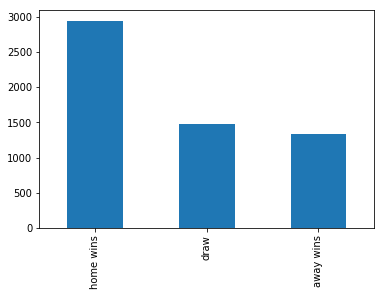

In [130]:
plot_y = y.map({0: 'home wins', 1:'away wins', 2: 'draw'})
# plot_y = y.map({0: 'home wins', 1:'away wins or draw'})
plot_y.value_counts().plot.bar()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV


param_ada = {'n_estimators': [10, 100, 200, 400],
             'learning_rate': [0.001, 0.005, .01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 10, 20]}

param_rf = {'max_depth': [2, 3, 4, 5],
            'n_estimators': list(range(50, 200, 30)),
            'min_samples_split': list(range(2, 7)),
            'min_samples_leaf': list(range(1, 7)), }

param_mlp = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'max_iter': [500]
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'adaptive'],
}

params_nb = {
    'alpha': np.linspace(0.5, 3, 10),
    'fit_prior': [True, False],
}

algorithms = [AdaBoostClassifier(), RandomForestClassifier(), MLPClassifier(), MultinomialNB()]
params = [param_ada, param_rf, param_mlp, params_nb]

scorer = make_scorer(accuracy_score)
clfs = []
for param, classifier in zip(params, algorithms):
    grid_obj = GridSearchCV(classifier, param,
                            scoring=scorer, verbose=100)
    grid_fit = grid_obj.fit(X_train, y_train)
    clfs.append(grid_fit.best_estimator_)

# algorithms = [AdaBoostClassifier(), RandomForestClassifier(), MLPClassifier(), MultinomialNB()]
names = ['AdaBoost', 'RandomForest', 'MLP', 'Multinomial NB']
accuracies = []
f1_scores = []
predictions = []

for i, clf, name in zip(range(len(clfs)), clfs, names):
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    accuracies.append(accuracy_score(y_test, preds))
    f1_scores.append(f1_score(y_test, preds, average=None))
    predictions.append(preds)
    print(f'accuracy {name}:', accuracy_score(y_test, preds))
    print(f'f1_score by class: {name}', f1_score(y_test, preds, average=None))

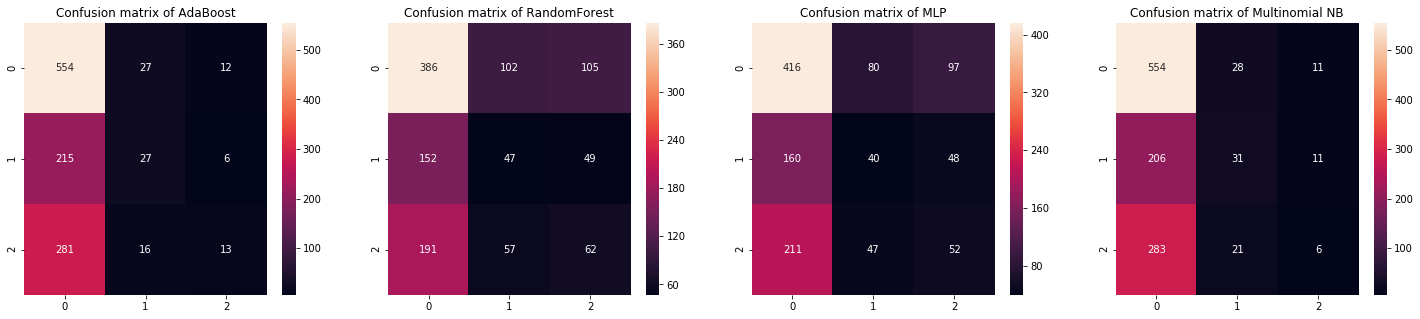

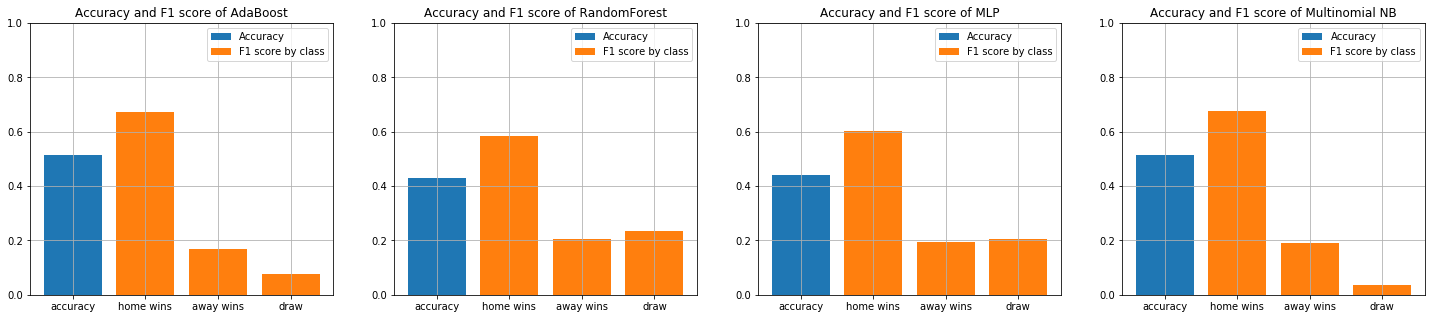

In [165]:
f, ax = plt.subplots(1, 4, figsize=(25,5))
for i, preds, name in zip(range(4), predictions, names):
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='g', ax=ax[i])
    ax[i].set_title(f'Confusion matrix of {name}')
    
f, ax = plt.subplots(1, 4, figsize=(25,5))

for i, acc, f1s, name in zip(range(4), accuracies, f1_scores, names):
    ax[i].bar('accuracy', acc, label='Accuracy')
    ax[i].bar(['home wins', 'away wins', 'draw'], f1s, label='F1 score by class')
    ax[i].legend()
    ax[i].grid(True)
    ax[i].set_title(f'Accuracy and F1 score of {name}')
    ax[i].set_ylim(0, 1)

### Prediction of 2017

In [132]:
dt_2017 = get_data_3('2017')
dt_2017 = insert_previous_results(dt_2017)

b'Skipping line 2: expected 1 fields, saw 2\nSkipping line 5: expected 1 fields, saw 2\nSkipping line 13: expected 1 fields, saw 2\nSkipping line 17: expected 1 fields, saw 2\nSkipping line 21: expected 1 fields, saw 2\nSkipping line 28: expected 1 fields, saw 2\nSkipping line 32: expected 1 fields, saw 2\nSkipping line 36: expected 1 fields, saw 2\nSkipping line 43: expected 1 fields, saw 2\nSkipping line 47: expected 1 fields, saw 2\nSkipping line 51: expected 1 fields, saw 2\nSkipping line 58: expected 1 fields, saw 2\nSkipping line 62: expected 1 fields, saw 2\nSkipping line 64: expected 1 fields, saw 2\nSkipping line 70: expected 1 fields, saw 2\nSkipping line 77: expected 1 fields, saw 2\nSkipping line 80: expected 1 fields, saw 2\nSkipping line 88: expected 1 fields, saw 2\nSkipping line 92: expected 1 fields, saw 2\nSkipping line 101: expected 1 fields, saw 2\nSkipping line 106: expected 1 fields, saw 2\nSkipping line 110: expected 1 fields, saw 2\nSkipping line 117: expected 1

In [133]:
X_2017 = pd.get_dummies(dt_2017[['home', 'away']])
X_2017[['home previous', 'away previous']] = dt_2017[['home previous', 'away previous']]

y_2017 = dt_2017['result'].astype(np.int)

X_2017 = pd.concat([pd.DataFrame(columns=X.columns), X_2017])
X_2017 = X_2017.fillna(0)

/home/paulorocha/Documents/DataScienceBrChallenge/env/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


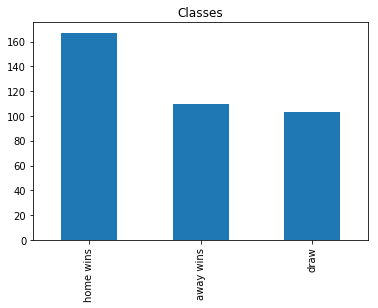

In [170]:
plot_y = y_2017.map({0: 'home wins', 1:'away wins', 2: 'draw'})

plot_y.value_counts().plot.bar(title='Classes')

In [167]:
accuracies = []
f1_scores = []
predictions = []

for i, clf, name in zip(range(len(clfs)), clfs, names):
    preds_2017 = clf.predict(X_2017)
    
    accuracies.append(accuracy_score(y_2017, preds_2017))
    f1_scores.append(f1_score(y_2017, preds_2017, average=None))
    predictions.append(preds_2017)
    print(f'accuracy {name}:', accuracy_score(y_2017, preds_2017))
    print(f'f1_score by class: {name}', f1_score(y_2017, preds_2017, average=None))

accuracy AdaBoost: 0.42105263157894735
f1_score by class: AdaBoost [0.58333333 0.25698324 0.064     ]
accuracy RandomForest: 0.3973684210526316
f1_score by class: RandomForest [0.54326923 0.25531915 0.17948718]
accuracy MLP: 0.3973684210526316
f1_score by class: MLP [0.52238806 0.24277457 0.27027027]
accuracy Multinomial NB: 0.4
f1_score by class: Multinomial NB [0.55427252 0.26666667 0.09090909]


/home/paulorocha/Documents/DataScienceBrChallenge/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5, 1.0, 'Confusion matrix of all home wins')

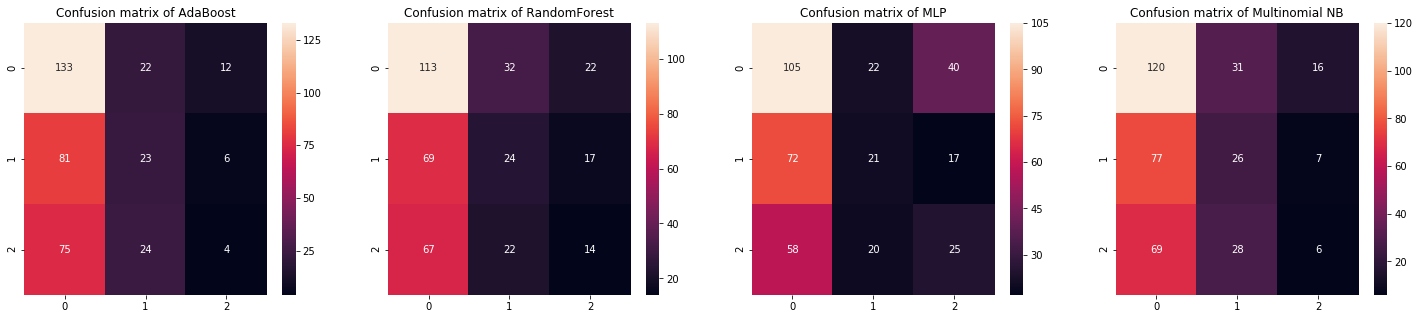

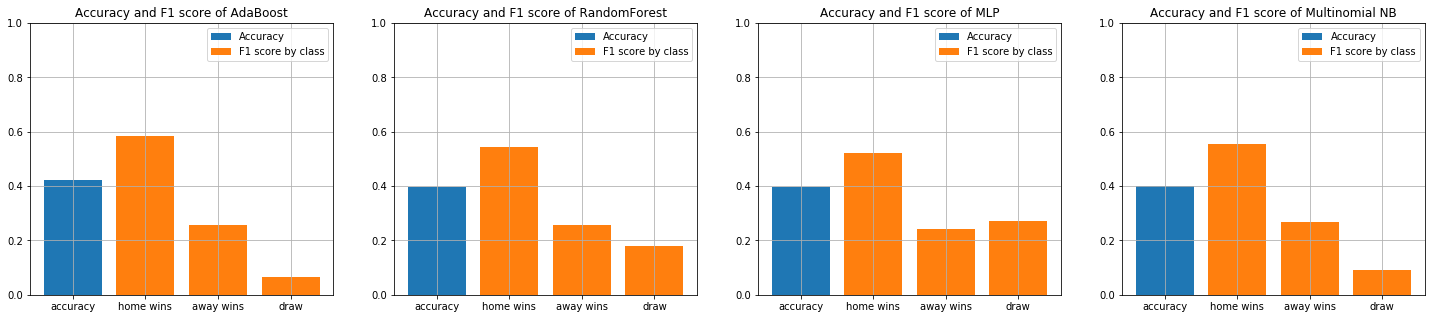

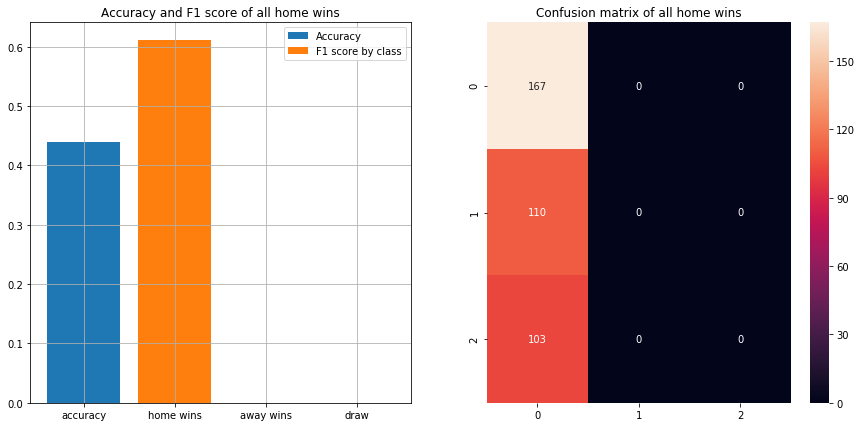

In [169]:
f, ax = plt.subplots(1, 4, figsize=(25,5))
for i, preds, name in zip(range(4), predictions, names):
    sns.heatmap(confusion_matrix(y_2017, preds), annot=True, fmt='g', ax=ax[i])
    ax[i].set_title(f'Confusion matrix of {name}')
    
f, ax = plt.subplots(1, 4, figsize=(25,5))

for i, acc, f1s, name in zip(range(4), accuracies, f1_scores, names):
    ax[i].bar('accuracy', acc, label='Accuracy')
    ax[i].bar(['home wins', 'away wins', 'draw'], f1s, label='F1 score by class')
    ax[i].legend()
    ax[i].grid(True)
    ax[i].set_title(f'Accuracy and F1 score of {name}')
    ax[i].set_ylim(0, 1)

preds_all_win = np.full(y_2017.shape, 0)
    
f, ax = plt.subplots(1, 2, figsize=(15,7))
    
ax[0].bar('accuracy', accuracy_score(y_2017, preds_all_win), label='Accuracy')
ax[0].bar(['home wins', 'away wins', 'draw'], f1_score(y_2017, preds_all_win, average=None), label='F1 score by class')
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Accuracy and F1 score of all home wins')
sns.heatmap(confusion_matrix(y_2017, preds_all_win), annot=True, fmt='g', ax=ax[1])
ax[1].set_title('Confusion matrix of all home wins')

In [178]:
# predictions of AdaBoost
dt_2017['predict result'] = predictions[0]
dt_2017['predict diff'] = predictions[0] == dt_2017['result']

dt_2017[['home', 'away', 'result', 'predict result', 'predict diff','home previous', 'away previous']]

,home,away,result,predict result,predict diff,home previous,away previous
0,flamengo,atléticomg,2.0,0,False,0.0,0.0
1,corinthians,chapecoense,2.0,0,False,0.0,0.0
2,fluminense,santos,0.0,0,True,0.0,0.0
3,palmeiras,vasco,0.0,0,True,0.0,0.0
4,cruzeiro,sãopaulo,0.0,2,False,0.0,0.0
5,bahia,atléticopr,0.0,0,True,0.0,0.0
6,pontepreta,sport,0.0,0,True,0.0,0.0
7,avaí,vitória,2.0,1,False,0.0,0.0
8,grêmio,botafogo,0.0,0,True,0.0,0.0
9,coritiba,atléticogo,0.0,0,True,0.0,0.0
